In [3]:
from tensorflow.keras.utils import normalize
import os
import glob
import random
import cv2
from tensorflow import keras
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import albumentations as A
import albumentations.augmentations.functional as F
from tqdm import tqdm
import tensorflow as tf

In [2]:
# !pip list
# !pip uninstall opencv-python-headless==4.5.5.62
# !pip install opencv-python-headless==4.1.2.30

Found existing installation: opencv-python-headless 4.5.5.64
Uninstalling opencv-python-headless-4.5.5.64:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless-4.5.5.64.dist-info/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavcodec-65fa80df.so.58.134.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavformat-8ef5c7db.so.58.76.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavutil-9c768859.so.56.70.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libbz2-a273e504.so.1.0.6
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libcrypto-09fe7800.so.1.1
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libgfortran-91cc3cb1.so.3.0.0
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libopenblas-r0-f650aae0.3.3.so
    /usr/local/lib/python3.7/dis

In [4]:
from google.colab import drive

In [5]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:

# #Resizing images, if needed
# SIZE_X = 256 
# SIZE_Y = 256
# n_classes=24  # number of classes for segmentation

# #Capture training image info as a list
# train_images = []
root = os.path.join('/content/drive/MyDrive/Data')
images_directory = os.path.join(root, 'image_dataset')
masks_directory = os.path.join(root, 'binary_mask_dataset')


Size = 256
        

In [7]:
img_names = glob.glob('/content/drive/MyDrive/Data/image_dataset/*.jpg')
msk_names = glob.glob('/content/drive/MyDrive/Data/binary_mask_dataset/*.png')
print(len(img_names), len(msk_names))

361 361


In [8]:
images_filenames = list(sorted(os.listdir(images_directory)))
correct_images_filenames = [i for i in images_filenames if cv2.imread(os.path.join(images_directory, i)) is not None]

random.seed(42)
random.shuffle(correct_images_filenames)

train_images_filenames = correct_images_filenames[:266]
val_images_filenames = correct_images_filenames[266:-10]
test_images_filenames = images_filenames[-10:]

print(len(train_images_filenames), len(val_images_filenames), len(test_images_filenames))


266 85 10


In [9]:
# !pip install -U albumentations
!pip install --upgrade git+https://github.com/albumentations-team/albumentations

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-dtigiiar
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-dtigiiar


In [10]:
import albumentations as album
# from albumentations.pytorch import ToTensorV2

In [11]:

class_names = ['background', 'grass', 'dog', 'tree', 'sky', 'concrete/walkway']

class_rgb_values = [
                    [0,0,0], [0,128,0],[128,128,128], [0,0,128], [128,0,128], [128,0,0]
                    ]

In [13]:
# print(len(class_names), len(class_rgb_values))

In [19]:
select_classes = ['background', 'grass']

select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]



In [13]:
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

In [14]:
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map

In [15]:
# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image 
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified 
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

In [16]:
# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [20]:
class BackgroundDataset:

    
    def __init__(
            self, 
            images_filenames,
            images_directory,
            masks_directory,
            class_rgb_values=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.masks_directory = masks_directory
        
        
        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, idx):
        
        image_filename = self.images_filenames[idx]
        image = cv2.imread(os.path.join(self.images_directory, image_filename))
        image = cv2.resize(image, (256,256))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(
            os.path.join(self.masks_directory, image_filename.replace(".jpg", ".png")), cv2.COLOR_BGR2RGB,
        )
        mask = cv2.resize(mask, (256,256))
        
        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.images_filenames)

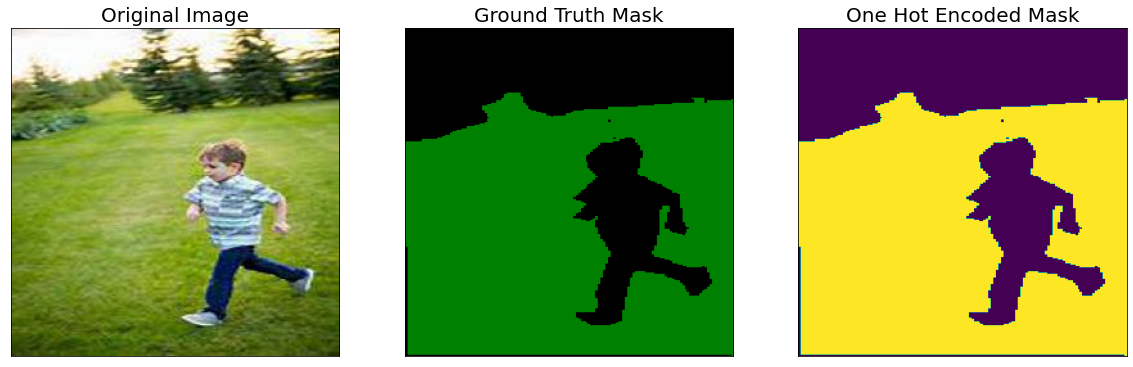

In [21]:
dataset = BackgroundDataset(images_filenames, images_directory, masks_directory, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[0]


visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)


In [21]:
class Dataloader(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   


In [22]:
# allMask = BackgroundDataset(images_filenames, images_directory, masks_directory, class_rgb_values=select_class_rgb_values)
# random_idx = random.randint(0, len(dataset)-1)
# # image, mask = allMask
# names = []
# for mask in msk_names:
#     name = mask.rsplit('/', 1)[1]
#     # name = mask[-4:]
#     names.append(name)

# c = 0
# for i, (img, msk) in enumerate(allMask):
#   #name = 'img'+str(c)+'.png'
#   ground_truth_mask = colour_code_segmentation(reverse_one_hot(msk), select_class_rgb_values)
#   pil = im = Image.fromarray((ground_truth_mask * 255).astype(np.uint8))
#   pil.save('/content/drive/MyDrive/Data/mask_dataset2/' + names[i])
#   c+=1

In [23]:
def get_training_augmentation(): #320
    train_transform = [
        album.PadIfNeeded(min_height=225, min_width=225, always_apply=True, border_mode=0),
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),
            ],
            p=0.5,
        ),
    ]
    return album.Compose(train_transform)


def get_validation_augmentation():
    # Add sufficient padding to ensure image is divisible by 32
    test_transform = [
        album.PadIfNeeded(min_height=225, min_width=225, always_apply=True, border_mode=0),
    ]
    return album.Compose(test_transform)


# def to_tensor(x, **kwargs):
#     return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform    
    Args:
        preprocessing_fn (callable): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """   
    _transform = [
        album.Lambda(image=preprocessing_fn),
    ]
    return album.Compose(_transform)
    # _transform = []
    # if preprocessing_fn:
    #     _transform.append(album.Lambda(image=preprocessing_fn))
    # _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
    # return album.Compose(_transform)

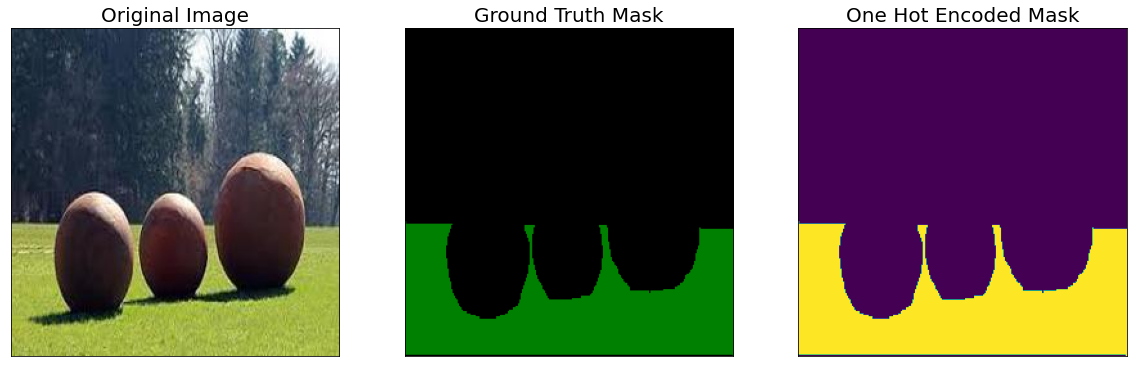

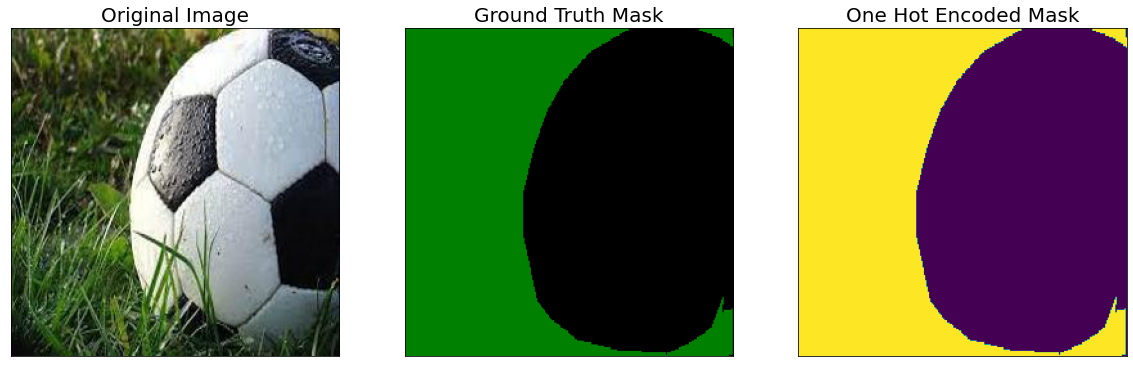

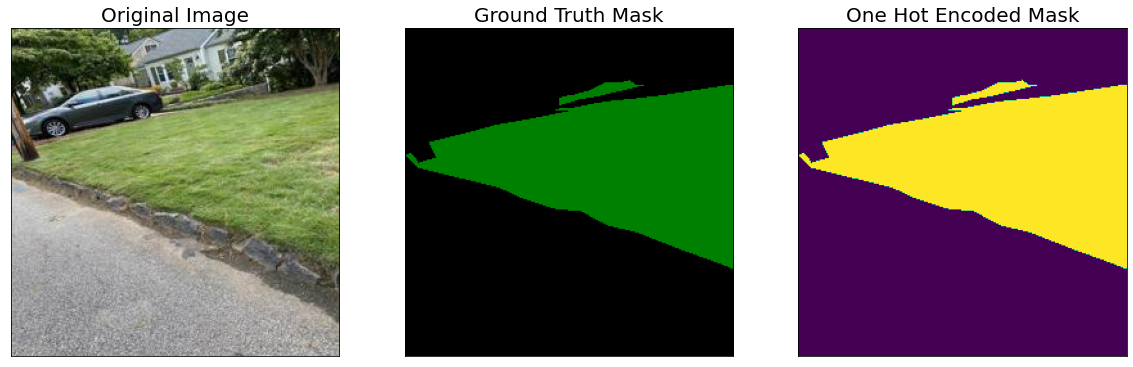

In [24]:
augmented_dataset = BackgroundDataset(
    train_images_filenames, images_directory, masks_directory, 
    augmentation=get_training_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

random_idx = random.randint(0, len(augmented_dataset)-1)

# Different augmentations on image/mask pairs
for idx in range(3):
    image, mask = augmented_dataset[idx]
    visualize(
        original_image = image,
        ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
        one_hot_encoded_mask = reverse_one_hot(mask)
    )

In [25]:
!pip install segmentation-models



In [26]:
import segmentation_models as sm

sm.set_framework('tf.keras')

sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

In [27]:
BACKBONE = 'resnet50'
# ENCODER_WEIGHTS = 'imagenet'
CLASSES = select_classes
# ACTIVATION = 'sigmoid' 

# # create segmentation model with pretrained encoder
# model = sm.Unet(
#     BACKBONE, 
#     # encoder_weights=ENCODER_WEIGHTS,
#     classes=len(CLASSES), 
#     activation=ACTIVATION
# )

preprocessing_fn = sm.get_preprocessing(BACKBONE)


In [28]:
LR = 0.0001

# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.5, 0.5])) 
focal_loss = sm.losses.BinaryFocalLoss() if CLASSES == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
# model.compile(optim, total_loss, metrics)

In [29]:
# Building Unet by dividing encoder and decoder into blocks

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
# from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [30]:
input_shape = (256, 256, 3)
model = build_unet(input_shape, n_classes=2)
model.compile(keras.optimizers.Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

softmax
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                     

In [31]:
# Get train and val dataset instances
train_dataset = BackgroundDataset(
    train_images_filenames, images_directory, masks_directory, 
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

valid_dataset = BackgroundDataset(
    val_images_filenames, images_directory, masks_directory, 
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

# Get train and val data loaders
train_loader = Dataloader(train_dataset, batch_size=4, shuffle=True)
valid_loader = Dataloader(valid_dataset, batch_size=4, shuffle=False)

In [32]:
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model2.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

In [33]:
EPOCHS = 15

# train model
history = model.fit(
    train_loader, 
    steps_per_epoch=len(train_loader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_loader, 
    validation_steps=len(valid_loader),
)

Epoch 1/15
66/66 [==============================] - 172s 2s/step - loss: 0.3398 - accuracy: 0.8620 - val_loss: 0.3205 - val_accuracy: 0.8858 - lr: 1.0000e-04
Epoch 2/15
66/66 [==============================] - 57s 860ms/step - loss: 0.2797 - accuracy: 0.8913 - val_loss: 0.3007 - val_accuracy: 0.8950 - lr: 1.0000e-04
Epoch 3/15
66/66 [==============================] - 57s 861ms/step - loss: 0.2704 - accuracy: 0.8964 - val_loss: 0.1937 - val_accuracy: 0.9267 - lr: 1.0000e-04
Epoch 4/15
66/66 [==============================] - 57s 860ms/step - loss: 0.2347 - accuracy: 0.9092 - val_loss: 0.4214 - val_accuracy: 0.8405 - lr: 1.0000e-04
Epoch 5/15
66/66 [==============================] - 57s 859ms/step - loss: 0.2193 - accuracy: 0.9159 - val_loss: 0.2264 - val_accuracy: 0.9157 - lr: 1.0000e-04
Epoch 6/15
66/66 [==============================] - 57s 865ms/step - loss: 0.2048 - accuracy: 0.9235 - val_loss: 0.1869 - val_accuracy: 0.9272 - lr: 1.0000e-04
Epoch 7/15
66/66 [========================

In [34]:
model.save("/content/drive/MyDrive/Data/my_grass.h5")

In [35]:
class BackgroundDataset_Test:

    
    def __init__(
            self, 
            images_filenames = None,
            images_directory = None,
            masks_directory = None,
            class_rgb_values=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.masks_directory = masks_directory
        
        
        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, idx):
        
        image_filename = self.images_filenames[idx]
        image = cv2.imread(os.path.join(self.images_directory, image_filename))
        image = cv2.resize(image, (256,256))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(
            os.path.join(self.masks_directory, image_filename.replace(".jpg", ".png")), cv2.COLOR_BGR2RGB,
        )
        mask = cv2.resize(mask, (256,256))
        
        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.images_filenames)

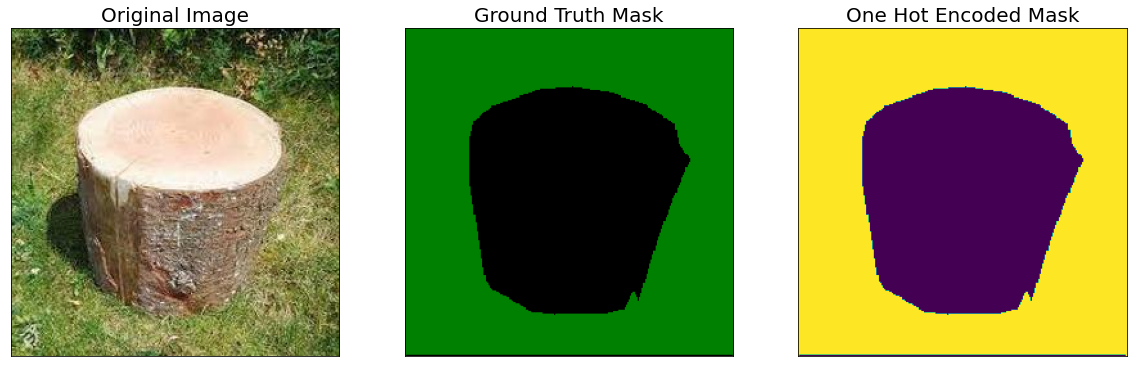

In [36]:
# create test dataloader to be used with UNet model (with preprocessing operation: to_tensor(...))
test_dataset = BackgroundDataset_Test(
    test_images_filenames, images_directory, masks_directory,
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

test_dataloader = Dataloader(test_dataset, batch_size=4, shuffle=True)

# test dataset for visualization (without preprocessing augmentations & transformations)
test_dataset_vis = BackgroundDataset_Test(
    test_images_filenames, images_directory, masks_directory,
    class_rgb_values=select_class_rgb_values,
)

# get a random test image/mask index
random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

In [37]:
# Center crop padded image / mask to original image dims
def crop_image(image, true_dimensions):
    return album.CenterCrop(p=1, height=true_dimensions[0], width=true_dimensions[1])(image=image)

In [38]:
sample_preds_folder = '/content/drive/MyDrive/Data/sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

In [39]:
for idx in range(len(test_dataset)):

    image, gt_mask = test_dataset[idx]
    image_vis = test_dataset_vis[idx][0].astype('uint8')
    true_dimensions = image_vis.shape
    # x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    # Predict test image
    image = np.expand_dims(image, axis=0)
    pred_mask = model.predict(image)
    # pred_mask = model(x_tensor)
    pred_mask = pred_mask.squeeze()
    # from CHW format to HWC format
    # pred_mask = np.transpose(pred_mask,(1,2,0))
    pred_mask = crop_image(colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values), true_dimensions)['image']
    # Convert gt_mask from `CHW` format to `HWC` format
    # gt_mask = np.transpose(gt_mask,(1,2,0))
    gt_mask = crop_image(colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values), true_dimensions)['image']
    # cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1])
    
    visualize(
        original_image = image_vis,
        ground_truth_mask = gt_mask,
        predicted_mask = pred_mask,
        
    )

Output hidden; open in https://colab.research.google.com to view.

KeyError: ignored

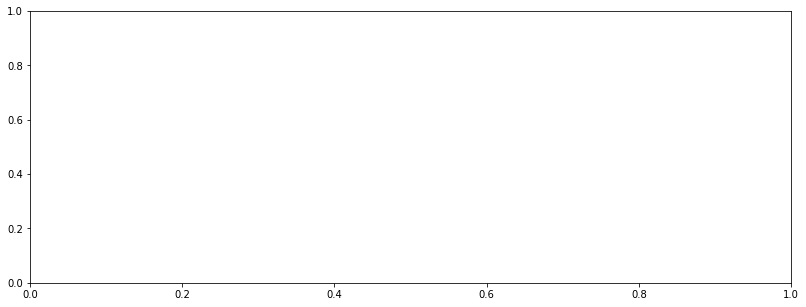

In [40]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [41]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Loss: 0.072246
mean iou_score: 0.98008


In [ ]:
# load_model = tf.keras.models.load_model("best_model.h5")


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

In [ ]:
tfLite_model_name = "tf_grass_net2.tflite"
tflite_model = converter.convert()
open(tfLite_model_name, "wb").write(tflite_model)

In [ ]:

from tensorflow import keras
import tensorflow as tf
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
import numpy as np


# model = keras.models.load_model('models/wpod_net_all_in_one.h5')

# Convert Keras model to ConcreteFunction
full_model = tf.function(lambda x: model(x))
full_model = full_model.get_concrete_function(
    x=tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))

# Get frozen ConcreteFunction
frozen_func = convert_variables_to_constants_v2(full_model)
frozen_func.graph.as_graph_def()

# inspect the layers operations inside your frozen graph definition and see the name of its input and output tensors
layers = [op.name for op in frozen_func.graph.get_operations()]
print("-" * 50)
print("Frozen model layers: ")
for layer in layers:
    print(layer)

print("-" * 50)
print("Frozen model inputs: ")
print(frozen_func.inputs)
print("Frozen model outputs: ")
print(frozen_func.outputs)

# Save frozen graph from frozen ConcreteFunction to hard drive
# serialize the frozen graph and its text representation to disk.
tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                  logdir="/content/drive/MyDrive/Data/",
                  name="simple_frozen_graph.pb",
                  as_text=False)

#Optional
# tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
#                   logdir="./frozen_models",
#                   name="simple_frozen_graph.pbtxt",
#                 as_text=True)

model.summary()

In [ ]:
converter = tf.compat.v1.lite.TFLiteConverter.from_frozen_graph(
    graph_def_file='/content/frozen_models/simple_frozen_graph.pb',
    input_arrays=['input'],
    input_shapes={'input' : [1, 256, 256, 3]}
)
converter.optimizations = {tf.lite.Optimize.DEFAULT}
converter.change_concat_input_ranges=True
tflite_model = converter.convert()

In [ ]:
interpreter = tf.lite.Interpreter(model_path="tf_grass_net2.tflite")
interpreter.allocate_tensors()

# Print input shape and type
inputs = interpreter.get_input_details()
print('{} input(s):'.format(len(inputs)))
for i in range(0, len(inputs)):
    print('{} {}'.format(inputs[i]['shape'], inputs[i]['dtype']))

# Print output shape and type
outputs = interpreter.get_output_details()
print('\n{} output(s):'.format(len(outputs)))
for i in range(0, len(outputs)):
    print('{} {}'.format(outputs[i]['shape'], outputs[i]['dtype']))

In [ ]:
done = 'Done'

In [4]:
from tensorflow.keras.models import Model
# from tf.keras.models import load_model
from tensorflow.keras.layers import Activation, Lambda, Reshape

In [5]:
# Load keras model
k_model=tf.keras.models.load_model('/content/drive/MyDrive/Data/my_grass.h5')
# k_model.summary()

In [6]:
# Flatten output
output = k_model.output
newout=Reshape((65536,))(output)
reshape_model=Model(k_model.input,newout)
reshape_model.summary()

ValueError: ignored